In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
warnings.filterwarnings("ignore")

Data load

In [ ]:
print('Image(Train):',len(os.listdir('/content/drive/MyDrive/data/training_images')))
print('Image(Test):',len(os.listdir('/content/drive/MyDrive/data/testing_images')))

Image(Train): 1001
Image(Test): 175


In [ ]:
Data=pd.read_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv')

In [ ]:
Data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [ ]:
print('Train data localization:',len(Data))

Train data localization: 559


Photo shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: ['vid_4_1000.jpg' 281.2590449 187.0350708 327.7279305 223.225547]


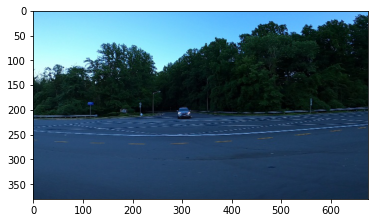

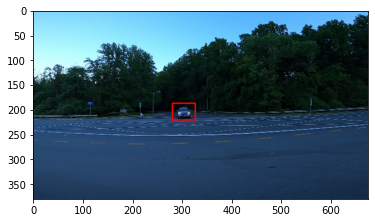

In [ ]:
for i in Data.values:
  photo=plt.imread(f'/content/drive/MyDrive/data/training_images/{i[0]}')
  plt.imshow(photo)
  print('Photo shape:',photo.shape)
  print('Name,xmin,ymin,xmax,ymax:',i)
  pt1=(int(i[1]),int(i[2]))
  pt2=(int(i[3]),int(i[4]))
  color=(255, 0, 0)
  thickness = 2
  cv2.rectangle(photo,pt1,pt2, color, thickness)
  plt.figure()
  plt.imshow(photo)
  break


Annotations (Check)

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


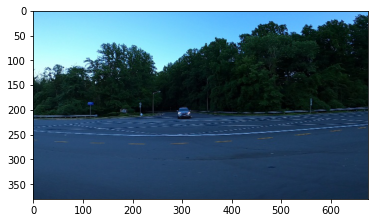

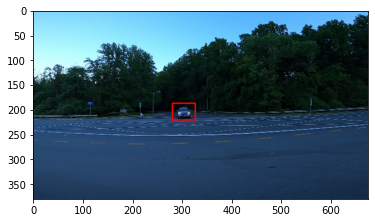

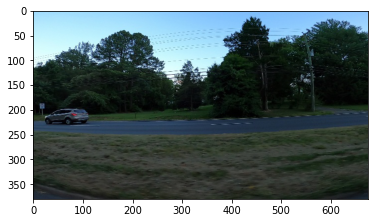

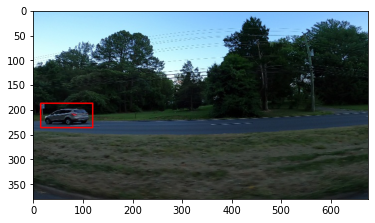

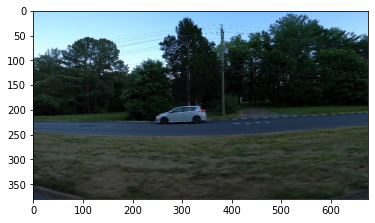

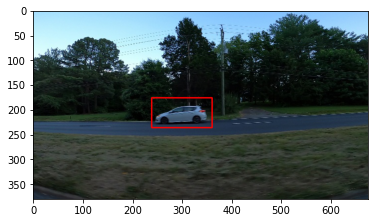

In [ ]:
for a,i in enumerate(Data.values):
  img=plt.imread('/content/drive/MyDrive/data/training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255, 0, 0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

Selective Search kullanimi

In [ ]:
cv2.setUseOptimized(True) # Optimeze
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Selective search obje

Shape: (224, 224, 3)
possible bounty boxes: 213


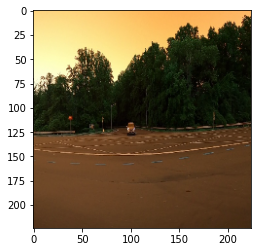

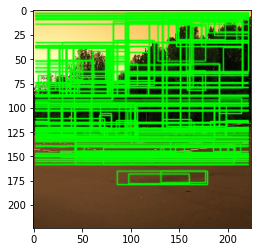

In [ ]:
im = cv2.imread('/content/drive/MyDrive/data/training_images/vid_4_1000.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) # GÖrüntünün yüklendiği kısım
ss.switchToSelectiveSearchFast() # Selective Search süresini hızlandırmak için
rects = ss.process()
print('Shape:',im.shape)
print('possible bounty boxes:',len(rects))

for rect in rects:
  x, y, w, h = rect
  imOut=cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

Selective search crop the image iou > 0.5 (Kullanimi)

Selective search

In [ ]:
#Iou and selective search 
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_liste=[]
k=0
l=0
z=0 #Loading
for a in pd.read_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv').values:
  Name,xmin,ymin,xmax,ymax=a
  bb1={ #gerçek bounty boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  try:
    img=cv2.imread('/content/drive/MyDrive/data/training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    for i in rects:
      x, y, w, h = i # Selective bounty boxxes
      bb2={'x1':x, 
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
      img1_shape=cv2.resize(img1,(224,224))
      if k<l:
            if 0.5<get_iou(bb1,bb2):  
              image_liste.append([img1_shape,1])
              k+=1
      else:
        if 0.5<get_iou(bb1,bb2):  
          image_liste.append([img1_shape,1])
          k+=1
        else:
          image_liste.append([img1_shape,0])
          l+=1
  except Exception as e:
    print('hata var',e)
  z+=1
  print(Name,z,len(rects))

vid_4_1000.jpg 1 1101
vid_4_10000.jpg 2 1456
vid_4_10040.jpg 3 1403
vid_4_10020.jpg 4 1489
vid_4_10060.jpg 5 1315
vid_4_10100.jpg 6 1537
vid_4_10120.jpg 7 1430
vid_4_10140.jpg 8 1543
vid_4_1020.jpg 9 1118
vid_4_1040.jpg 10 1146
vid_4_10480.jpg 11 1663
vid_4_10500.jpg 12 1815
vid_4_10520.jpg 13 1725
vid_4_1060.jpg 14 1244
vid_4_10960.jpg 15 1894
vid_4_10980.jpg 16 1676
vid_4_11000.jpg 17 1754
vid_4_11020.jpg 18 1553
vid_4_11240.jpg 19 1779
vid_4_11260.jpg 20 1863
vid_4_11280.jpg 21 1840
vid_4_11380.jpg 22 1884
vid_4_11400.jpg 23 1929
vid_4_11420.jpg 24 1925
vid_4_11440.jpg 25 1880
vid_4_11900.jpg 26 1801
vid_4_11880.jpg 27 1824
vid_4_11920.jpg 28 1857
vid_4_11940.jpg 29 1947
vid_4_11960.jpg 30 1932
vid_4_11980.jpg 31 1970
vid_4_12000.jpg 32 1901
vid_4_12040.jpg 33 1979
vid_4_12100.jpg 34 1971
vid_4_12060.jpg 35 1879
vid_4_12080.jpg 36 1870
vid_4_12120.jpg 37 1821
vid_4_12140.jpg 38 1632
vid_4_12140.jpg 39 1632
vid_4_12160.jpg 40 1682
vid_4_12160.jpg 41 1682
vid_4_12160.jpg 42 1682
vid_4

In [ ]:
len(image_liste)

10583

In [ ]:
data=[]
data_label=[]
for features,label in image_liste:
  data.append(features)
  data_label.append(label)
print('successed')

successed


In [ ]:
print('Number of photos:',len(data),'|Label of photos:',len(data_label))

Number of photos: 10583 |Label of photos: 10583


Class: 0
Image size: (224, 224, 3)


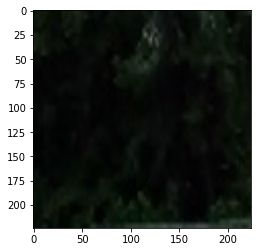

In [ ]:
i=random.randint(1,10583)
print('Class:',data_label[i])
print('Image size:',data[i].shape)
plt.imshow(data[i]);

In [ ]:
data=np.asarray(data)
data_label=np.asarray(data_label) 

In [ ]:
print('No car pictures:',len(data_label[data_label==0]),'|Car pictures:',len(data_label[data_label==1]))

No car pictures: 5292 |Car pictures: 5291


In [ ]:
data.shape

(10583, 224, 224, 3)

In [ ]:
data_label.shape

(10583,)

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data,data_label,test_size=0.33, random_state=42)

In [ ]:
print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

x_train shape: (7090, 224, 224, 3)
x_val shape: (3493, 224, 224, 3)
y_train shape: (7090,)
y_val shape: (3493,)


In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
base_model.trainable=False

In [ ]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False


In [ ]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

In [ ]:
epoch=4
hist=model.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

Epoch 1/4
222/222 [==============================] - 5287s 24s/step - loss: 0.6085 - accuracy: 0.8312 - val_loss: 0.1739 - val_accuracy: 0.9559
Epoch 2/4
 16/222 [=>............................] - ETA: 54:47 - loss: 0.3170 - accuracy: 0.9082

KeyboardInterrupt: ignored

In [ ]:
car=[]
photo_path='/content/drive/MyDrive/data/testing_images/vid_5_27620.jpg'
deneme_img=cv2.imread(photo_path)
ss.setBaseImage(deneme_img)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()
print('Number of possible objects in the photo: ',len(rects1))
for i in rects1:
  x, y, w, h = i
  bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }
  try:
    assert bb3['x1'] < bb3['x2']
    assert bb3['y1'] < bb3['y2']
    img_data=deneme_img[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
    img_data=cv2.resize(img_data,(224,224))
    tahmin=model.predict(img_data.reshape(1,224,224,3))
    if tahmin[0]>0.5:
      car.append([bb3,tahmin[0]])
    else:
      pass
  except Exception as e:
    print('e: ',e)
print('how many possible bounty boxes with a class prediction of 1 are there:',len(car))
print('-------------------------------------------------------------------------')
deneme_img=cv2.imread(photo_path)
car[np.argmax(np.array(car)[:,1])][0]
pt1=(car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2=(car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(deneme_img)
cv2.rectangle(deneme_img,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'Class numarası 1 highest probability bounty box score: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}') 
plt.imshow(deneme_img);

In [ ]:
! git init 

Initialized empty Git repository in /content/.git/


In [ ]:
!git clone https://github.com/doflamingo0/cv.git

Cloning into 'cv'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7 (delta 0), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [ ]:
! git remote -v

origin	https://github.com/doflamingo0/cv.git (fetch)
origin	https://github.com/doflamingo0/cv.git (push)


In [ ]:
%cd {repo}

[Errno 2] No such file or directory: '{repo}'
/content/cv


In [ ]:
%ls

readme.md


In [ ]:
! git checkout rcnn

Branch 'rcnn' set up to track remote branch 'rcnn' from 'origin'.
Switched to a new branch 'rcnn'


In [ ]:
! git config --global user.email "ndhieubk1999@gmail.com"
! git config --global user.name "hieund1901"

In [ ]:
! git add .

In [ ]:
! git commit -m "Add code rcnn"

On branch rcnn
Your branch is up to date with 'origin/rcnn'.

nothing to commit, working tree clean
